In [2]:
import pandas as pd

# Load the uploaded training dataset
data = pd.ExcelFile('Training dataset.xlsx')

# Display the names of all sheets in the Excel file to understand its structure
data.sheet_names


['Sheet1']

In [3]:
# Load the data from the first sheet
df = data.parse('Sheet1')

# Display the first few rows to understand the structure of the dataset
df.head()


,date,y,y_lag,cpi,m4,m4_lend,loans,net_lend,br,gscpi,...,P3H_QoQ,P3N_QoQ,P51_QoQ,P51S_QoQ,P6_QoQ,P7_QoQ,Q_MoM,R_MoM,S_MoM,T_MoM
0,1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-02-01,NaN,NaN,70.254,10.9,8.2,NaN,NaN,7.25,-1.073170,...,NaN,NaN,NaN,NaN,NaN,NaN,0.5,-6.8,-1.5,-1.8
2,1998-03-01,0.7,NaN,70.498,10.7,9.3,NaN,NaN,7.25,-0.435580,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,-3.8,-1.8,-1.4
3,1998-04-01,NaN,0.7,70.700,10.0,8.7,NaN,NaN,7.25,-0.060024,...,0.8,1.3,0.8,1.6,0.6,2.6,-0.2,-3.6,-1.1,-2.0
4,1998-05-01,NaN,NaN,71.072,10.8,9.2,NaN,NaN,7.25,-0.118535,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-3.1,1.4,2.7


In [4]:
# Step 1: Check for missing values in the critical columns (y, explanatory variables)
missing_summary = df[['date', 'y', 'y_lag', 'cpi', 'm4', 'm4_lend', 'loans', 'net_lend', 'br', 'gscpi']].isnull().sum()

# Step 2: Ensure the 'date' column is properly formatted and set as the index for time series alignment
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')  # Sort by date

# Display the missing value summary and the cleaned date column
missing_summary, df[['date']].head()


(date          0
 y           200
 y_lag       201
 cpi           1
 m4            1
 m4_lend       1
 loans        14
 net_lend    138
 br            1
 gscpi         1
 dtype: int64,
         date
 0 1998-01-01
 1 1998-02-01
 2 1998-03-01
 3 1998-04-01
 4 1998-05-01)

In [6]:
# Step 1: Convert monthly predictors into quarterly data by aggregating them
# We will use mean aggregation for most predictors to represent the quarter's average conditions
# Other options could involve using the last month's value of each quarter if specified

# First, resample the dataset by quarter (keeping date aligned properly)
quarterly_df = df.resample('Q', on='date').mean().reset_index()

# Step 2: Check and handle missing values in the explanatory variables (forward fill for minimal gaps)
quarterly_df[['cpi', 'm4', 'm4_lend', 'loans', 'net_lend', 'br', 'gscpi']] = quarterly_df[
    ['cpi', 'm4', 'm4_lend', 'loans', 'net_lend', 'br', 'gscpi']
].fillna(method='ffill')

# Step 3: Ensure the lagged variable (y_lag) is correctly aligned with quarterly y predictions
# Shift y to create a lagged column reflecting the last available y for each quarter
quarterly_df['y_lag'] = quarterly_df['y'].shift(1)

# Step 4: Final check for any remaining missing values in critical columns
final_missing_summary = quarterly_df[['date', 'y', 'y_lag', 'cpi', 'm4', 'm4_lend', 'loans', 'net_lend', 'br', 'gscpi']].isnull().sum()

# Display the cleaned dataset and summary of remaining missing values
quarterly_df.head()


,date,y,y_lag,cpi,m4,m4_lend,loans,net_lend,br,gscpi,...,P3H_QoQ,P3N_QoQ,P51_QoQ,P51S_QoQ,P6_QoQ,P7_QoQ,Q_MoM,R_MoM,S_MoM,T_MoM
0,1998-03-31,0.7,NaN,70.376000,10.800000,8.750000,NaN,NaN,7.250000,-0.754375,...,NaN,NaN,NaN,NaN,NaN,NaN,0.200000,-5.300000e+00,-1.650000,-1.600000
1,1998-06-30,0.8,0.7,71.073667,10.200000,8.800000,NaN,NaN,7.250000,-0.199842,...,0.8,1.3,0.8,1.6,0.6,2.6,-0.300000,-1.700000e+00,0.300000,-0.500000
2,1998-09-30,0.7,0.8,71.177667,9.700000,8.533333,NaN,NaN,7.488636,-0.839788,...,1.0,-0.9,-0.1,-0.4,0.1,2.4,0.166667,4.100000e+00,-0.466667,-0.400000
3,1998-12-31,0.9,0.7,71.557333,9.100000,8.666667,NaN,NaN,7.209416,-0.788610,...,1.7,-1.2,-0.9,-0.9,-0.3,0.7,0.233333,-1.500000e+00,1.133333,-0.033333
4,1999-03-31,0.5,0.9,71.554667,7.933333,7.466667,2852.0,NaN,6.009722,-0.254643,...,0.0,-1.6,2.1,2.5,-0.3,0.0,-0.166667,3.700743e-17,-2.233333,-2.600000


In [7]:
final_missing_summary

date         0
y            0
y_lag        1
cpi          0
m4           0
m4_lend      0
loans        4
net_lend    46
br           0
gscpi        0
dtype: int64

In [8]:
quarterly_df.columns

Index(['date', 'y', 'y_lag', 'cpi', 'm4', 'm4_lend', 'loans', 'net_lend', 'br',
       'gscpi', 'GBP/US', 'GBP/EU', 'unemply', 'awe', 'oil_pl', 'us_gdp',
       'eu_gdp', 'sr', 'imp', 'exp', 'expp', 'pop', 'visa', 'A_MoM', 'A_QoQ',
       'B_MoM', 'BE_MoM', 'BE_QoQ', 'C_MoM', 'C_QoQ', 'D_MoM', 'E_MoM',
       'F_MoM', 'F_QoQ', 'G_MoM', 'GT_MoM', 'GT_QoQ', 'GVA_MoM', 'H_MoM',
       'I_MoM', 'IOS_MoM', 'IOP_MoM', 'J_MoM', 'K_MoM', 'L_MoM', 'M_MoM',
       'O_MoM', 'N_MoM', 'P_MoM', 'P3G_QoQ', 'P3H_QoQ', 'P3N_QoQ', 'P51_QoQ',
       'P51S_QoQ', 'P6_QoQ', 'P7_QoQ', 'Q_MoM', 'R_MoM', 'S_MoM', 'T_MoM'],
      dtype='object')

In [9]:
# Step 1: Define the configurations for splitting
# Current quarter prediction, 1ahead (1 quarter ahead), 2ahead (2 quarters ahead)
quarterly_df['y_1ahead'] = quarterly_df['y'].shift(-1)  # Next quarter's y
quarterly_df['y_2ahead'] = quarterly_df['y'].shift(-2)  # Two quarters ahead y

# Step 2: Define training and test set split point (e.g., 80% train, 20% test)
split_index = int(len(quarterly_df) * 0.8)  # 80% for training, 20% for testing

# Step 3: Split the data for each configuration
train_current = quarterly_df[:split_index].drop(columns=['y_1ahead', 'y_2ahead'])
test_current = quarterly_df[split_index:].drop(columns=['y_1ahead', 'y_2ahead'])

train_1ahead = quarterly_df[:split_index].drop(columns=['y', 'y_2ahead'])
test_1ahead = quarterly_df[split_index:].drop(columns=['y', 'y_2ahead'])

train_2ahead = quarterly_df[:split_index].drop(columns=['y', 'y_1ahead'])
test_2ahead = quarterly_df[split_index:].drop(columns=['y', 'y_1ahead'])

# Step 4: Output the shapes of the splits to confirm they are correctly split
train_current.shape, test_current.shape, train_1ahead.shape, test_1ahead.shape, train_2ahead.shape, test_2ahead.shape


((80, 60), (20, 60), (80, 60), (20, 60), (80, 60), (20, 60))

In [108]:
train_current

,date,y,y_lag,cpi,m4,m4_lend,loans,net_lend,br,gscpi,...,R_MoM,S_MoM,T_MoM,GVA_MoM_lag1,GT_MoM_lag1,IOS_MoM_lag1,H_MoM_lag1,m4_lag1,loans_lag1,br_lag1
0,1998-03-31,0.7,NaN,70.376000,10.800000,8.750000,NaN,NaN,7.250000,-0.754375,...,-5.300000e+00,-1.650000,-1.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-06-30,0.8,0.7,71.073667,10.200000,8.800000,NaN,NaN,7.250000,-0.199842,...,-1.700000e+00,0.300000,-0.500000,0.235000,0.150000,0.150000,-0.150000,10.800000,NaN,7.250000
2,1998-09-30,0.7,0.8,71.177667,9.700000,8.533333,NaN,NaN,7.488636,-0.839788,...,4.100000e+00,-0.466667,-0.400000,0.076667,0.100000,0.100000,0.866667,10.200000,NaN,7.250000
3,1998-12-31,0.9,0.7,71.557333,9.100000,8.666667,NaN,NaN,7.209416,-0.788610,...,-1.500000e+00,1.133333,-0.033333,0.213333,0.233333,0.233333,-0.066667,9.700000,NaN,7.488636
4,1999-03-31,0.5,0.9,71.554667,7.933333,7.466667,2852.000000,NaN,6.009722,-0.254643,...,3.700743e-17,-2.233333,-2.600000,0.250000,0.233333,0.233333,0.666667,9.100000,NaN,7.209416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2016-12-31,0.6,0.3,101.254667,6.433333,3.633333,4707.666667,5236.000000,0.250000,-0.214650,...,1.566667e+00,0.066667,0.366667,0.203333,0.366667,0.366667,0.433333,4.300000,7142.666667,0.427536
76,2017-03-31,0.2,0.6,101.781333,6.366667,4.666667,3880.333333,9820.666667,0.250000,0.031149,...,7.000000e-01,1.000000,-2.300000,0.236667,0.333333,0.333333,-0.066667,6.433333,4707.666667,0.250000
77,2017-06-30,0.1,0.2,102.913333,7.266667,5.600000,5083.333333,7631.333333,0.250000,-0.020591,...,8.333333e-01,0.800000,0.633333,0.326667,0.233333,0.233333,0.366667,6.366667,3880.333333,0.250000
78,2017-09-30,0.2,0.1,103.428000,4.766667,5.500000,6812.000000,10875.333333,0.250000,0.188252,...,1.850372e-17,0.500000,0.966667,0.213333,0.233333,0.233333,-0.033333,7.266667,5083.333333,0.250000


In [11]:
train_1ahead

,date,y_lag,cpi,m4,m4_lend,loans,net_lend,br,gscpi,GBP/US,...,P3N_QoQ,P51_QoQ,P51S_QoQ,P6_QoQ,P7_QoQ,Q_MoM,R_MoM,S_MoM,T_MoM,y_1ahead
0,1998-03-31,NaN,70.376000,10.800000,8.750000,NaN,NaN,7.250000,-0.754375,1.638263,...,NaN,NaN,NaN,NaN,NaN,0.200000,-5.300000e+00,-1.650000,-1.600000,0.8
1,1998-06-30,0.7,71.073667,10.200000,8.800000,NaN,NaN,7.250000,-0.199842,1.657707,...,1.3,0.8,1.6,0.6,2.6,-0.300000,-1.700000e+00,0.300000,-0.500000,0.7
2,1998-09-30,0.8,71.177667,9.700000,8.533333,NaN,NaN,7.488636,-0.839788,1.642604,...,-0.9,-0.1,-0.4,0.1,2.4,0.166667,4.100000e+00,-0.466667,-0.400000,0.9
3,1998-12-31,0.7,71.557333,9.100000,8.666667,NaN,NaN,7.209416,-0.788610,1.679798,...,-1.2,-0.9,-0.9,-0.3,0.7,0.233333,-1.500000e+00,1.133333,-0.033333,0.5
4,1999-03-31,0.9,71.554667,7.933333,7.466667,2852.000000,NaN,6.009722,-0.254643,1.649959,...,-1.6,2.1,2.5,-0.3,0.0,-0.166667,3.700743e-17,-2.233333,-2.600000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2016-12-31,0.3,101.254667,6.433333,3.633333,4707.666667,5236.000000,0.250000,-0.214650,1.263410,...,-0.7,2.8,2.4,-2.7,3.4,0.433333,1.566667e+00,0.066667,0.366667,0.2
76,2017-03-31,0.6,101.781333,6.366667,4.666667,3880.333333,9820.666667,0.250000,0.031149,1.243498,...,0.5,-0.9,-3.7,4.0,-2.4,0.966667,7.000000e-01,1.000000,-2.300000,0.1
77,2017-06-30,0.2,102.913333,7.266667,5.600000,5083.333333,7631.333333,0.250000,-0.020591,1.263770,...,1.8,1.7,2.3,1.7,1.2,0.266667,8.333333e-01,0.800000,0.633333,0.2
78,2017-09-30,0.1,103.428000,4.766667,5.500000,6812.000000,10875.333333,0.250000,0.188252,1.291965,...,2.2,1.2,-0.5,2.7,2.7,-0.600000,1.850372e-17,0.500000,0.966667,0.2


In [12]:
train_2ahead

,date,y_lag,cpi,m4,m4_lend,loans,net_lend,br,gscpi,GBP/US,...,P3N_QoQ,P51_QoQ,P51S_QoQ,P6_QoQ,P7_QoQ,Q_MoM,R_MoM,S_MoM,T_MoM,y_2ahead
0,1998-03-31,NaN,70.376000,10.800000,8.750000,NaN,NaN,7.250000,-0.754375,1.638263,...,NaN,NaN,NaN,NaN,NaN,0.200000,-5.300000e+00,-1.650000,-1.600000,0.7
1,1998-06-30,0.7,71.073667,10.200000,8.800000,NaN,NaN,7.250000,-0.199842,1.657707,...,1.3,0.8,1.6,0.6,2.6,-0.300000,-1.700000e+00,0.300000,-0.500000,0.9
2,1998-09-30,0.8,71.177667,9.700000,8.533333,NaN,NaN,7.488636,-0.839788,1.642604,...,-0.9,-0.1,-0.4,0.1,2.4,0.166667,4.100000e+00,-0.466667,-0.400000,0.5
3,1998-12-31,0.7,71.557333,9.100000,8.666667,NaN,NaN,7.209416,-0.788610,1.679798,...,-1.2,-0.9,-0.9,-0.3,0.7,0.233333,-1.500000e+00,1.133333,-0.033333,0.0
4,1999-03-31,0.9,71.554667,7.933333,7.466667,2852.000000,NaN,6.009722,-0.254643,1.649959,...,-1.6,2.1,2.5,-0.3,0.0,-0.166667,3.700743e-17,-2.233333,-2.600000,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2016-12-31,0.3,101.254667,6.433333,3.633333,4707.666667,5236.000000,0.250000,-0.214650,1.263410,...,-0.7,2.8,2.4,-2.7,3.4,0.433333,1.566667e+00,0.066667,0.366667,0.1
76,2017-03-31,0.6,101.781333,6.366667,4.666667,3880.333333,9820.666667,0.250000,0.031149,1.243498,...,0.5,-0.9,-3.7,4.0,-2.4,0.966667,7.000000e-01,1.000000,-2.300000,0.2
77,2017-06-30,0.2,102.913333,7.266667,5.600000,5083.333333,7631.333333,0.250000,-0.020591,1.263770,...,1.8,1.7,2.3,1.7,1.2,0.266667,8.333333e-01,0.800000,0.633333,0.2
78,2017-09-30,0.1,103.428000,4.766667,5.500000,6812.000000,10875.333333,0.250000,0.188252,1.291965,...,2.2,1.2,-0.5,2.7,2.7,-0.600000,1.850372e-17,0.500000,0.966667,0.1


# Exploratory Analysis 

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Descriptive statistics
descriptive_stats = quarterly_df.describe()

# Step 2: Correlation analysis (correlation with y for current quarter prediction)
correlation_matrix = quarterly_df.corr()
correlation_with_y = correlation_matrix['y'].sort_values(ascending=False)



descriptive_stats


C:\Users\OWNER\AppData\Local\Temp\ipykernel_28708\2266586733.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = quarterly_df.corr()


,y,y_lag,cpi,m4,m4_lend,loans,net_lend,br,gscpi,GBP/US,...,P51_QoQ,P51S_QoQ,P6_QoQ,P7_QoQ,Q_MoM,R_MoM,S_MoM,T_MoM,y_1ahead,y_2ahead
count,100.000000,99.000000,100.000000,100.000000,100.000000,96.000000,54.000000,100.000000,100.000000,100.000000,...,99.000000,99.000000,99.000000,99.000000,100.000000,100.000000,100.000000,100.000000,99.000000,98.000000
mean,0.268000,0.270707,90.384013,5.969333,6.026833,5948.263889,2802.537037,2.520753,0.034960,1.557817,...,0.554545,0.697980,0.844444,0.970707,0.141333,0.117667,0.148167,0.141333,0.263636,0.258163
std,2.699827,2.713430,14.449510,5.103107,6.146649,4767.094805,8167.304626,2.370466,0.996070,0.208527,...,3.700807,7.826238,3.828577,4.555424,1.906184,3.300816,2.321443,6.233538,2.713212,2.726613
min,-20.500000,-20.500000,70.376000,-4.833333,-6.400000,-2427.000000,-17122.000000,0.100000,-1.067914,1.146095,...,-18.800000,-32.200000,-13.100000,-24.700000,-16.033333,-23.966667,-12.600000,-22.600000,-20.500000,-20.500000
25%,0.100000,0.100000,76.262250,1.816667,1.500000,2559.166667,-2388.416667,0.500000,-0.544662,1.391494,...,-0.900000,-1.600000,-0.650000,-0.400000,-0.166667,-0.508333,-0.533333,-2.525000,0.100000,0.100000
50%,0.400000,0.400000,89.296500,6.400000,5.700000,5243.333333,2215.333333,0.750000,-0.219487,1.562736,...,0.400000,0.300000,1.000000,1.100000,0.166667,0.133333,0.100000,-0.166667,0.400000,0.400000
75%,0.700000,0.700000,100.836917,9.758333,11.533333,9798.666667,8103.750000,4.750000,0.202008,1.651896,...,2.500000,3.400000,2.900000,2.700000,0.433333,0.850000,0.633333,2.116667,0.700000,0.700000
max,15.400000,15.400000,125.552333,16.766667,17.333333,18753.333333,23172.333333,7.488636,3.861168,2.044373,...,16.000000,55.600000,11.800000,17.300000,6.133333,15.333333,14.800000,23.366667,15.400000,15.400000


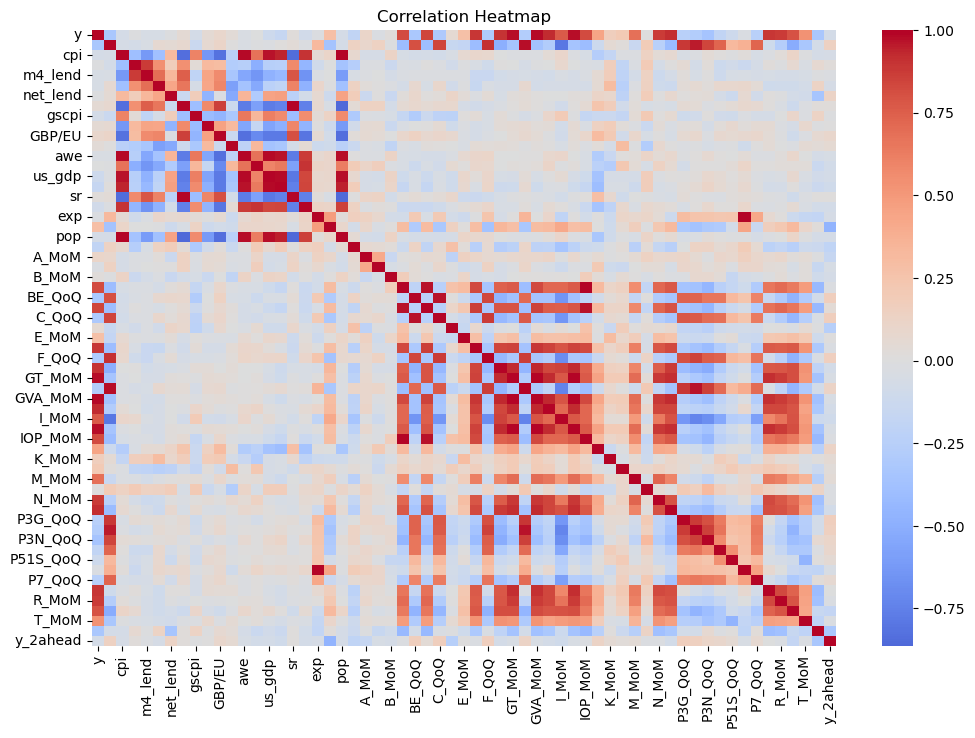

y           1.000000
GVA_MoM     0.984884
GT_MoM      0.975176
IOS_MoM     0.975176
H_MoM       0.924057
              ...   
C_QoQ      -0.308920
BE_QoQ     -0.320410
y_lag      -0.331725
y_1ahead   -0.331725
P3N_QoQ    -0.347775
Name: y, Length: 61, dtype: float64

In [16]:
# Step 3: Visualize correlation matrix for top predictors
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

correlation_with_y

In [111]:
correlation_with_y[1:17]

GVA_MoM    0.984884
GT_MoM     0.975176
IOS_MoM    0.975176
H_MoM      0.924057
P_MoM      0.918177
G_MoM      0.903763
Q_MoM      0.895468
F_MoM      0.893396
N_MoM      0.872306
R_MoM      0.871849
C_MoM      0.845009
IOP_MoM    0.822434
BE_MoM     0.822396
S_MoM      0.799466
I_MoM      0.765037
M_MoM      0.686744
Name: y, dtype: float64

### Time Series Analysis: Visualize key predictors over time to check for trends or seasonality.

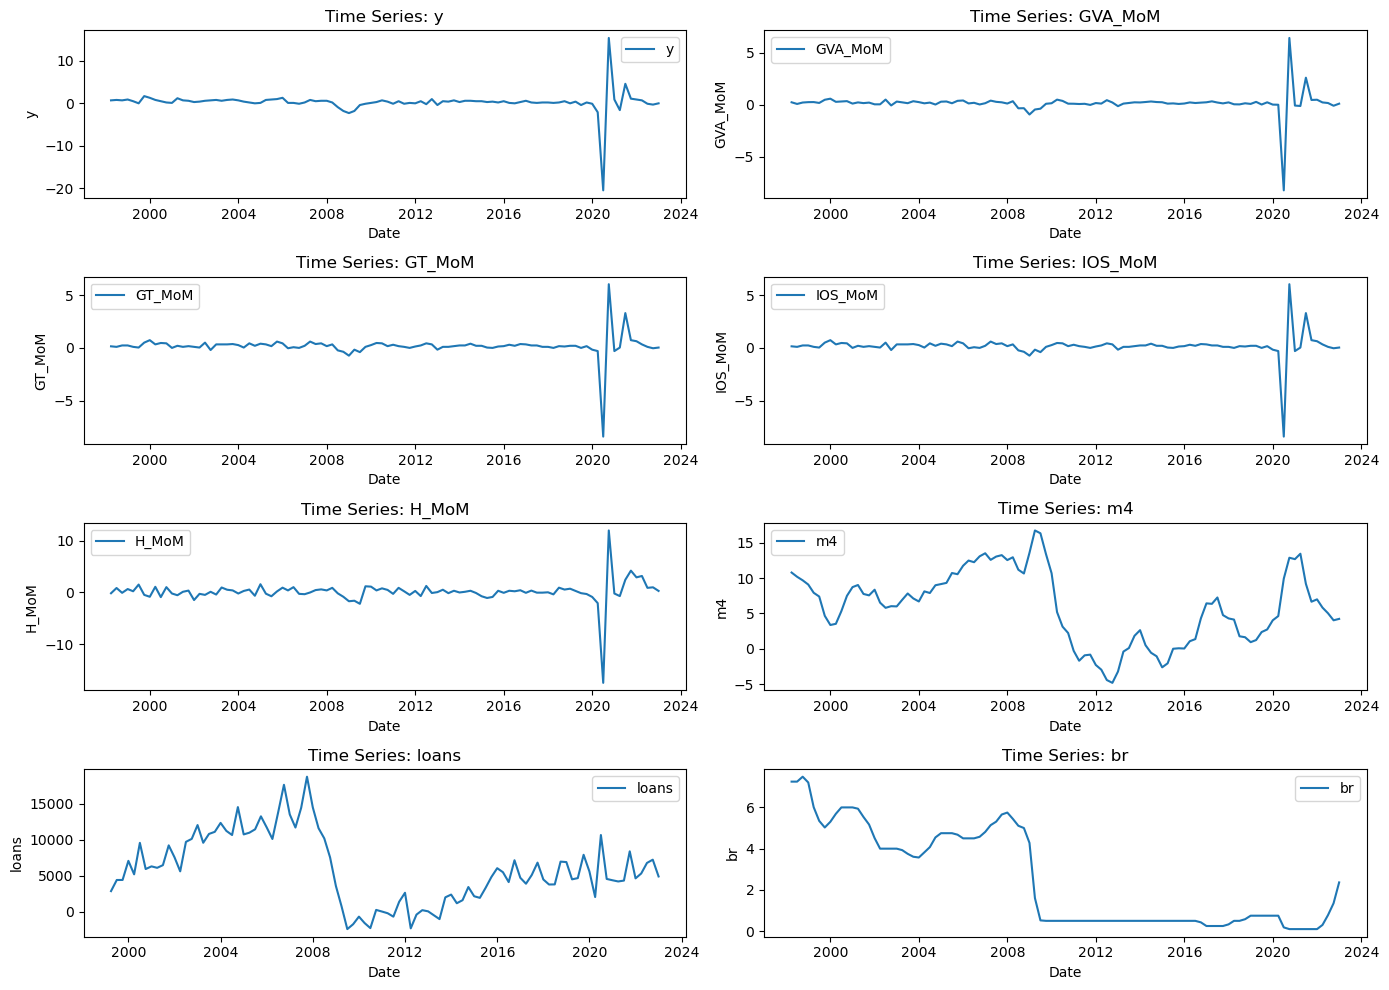

In [113]:
# Step 1: Select key predictors to visualize along with the target variable y
key_predictors = ['y', 'GVA_MoM', 'GT_MoM', 'IOS_MoM', 'H_MoM', 'm4', 'loans', 'br']

# Step 2: Plot the time series for key predictors and y to identify trends or seasonality
plt.figure(figsize=(14, 10))
for i, predictor in enumerate(key_predictors, start=1):
    plt.subplot(4, 2, i)
    plt.plot(quarterly_df['date'], quarterly_df[predictor], label=predictor)
    plt.title(f'Time Series: {predictor}')
    plt.xlabel('Date')
    plt.ylabel(predictor)
    plt.legend()

plt.tight_layout()
plt.show()


# WORK

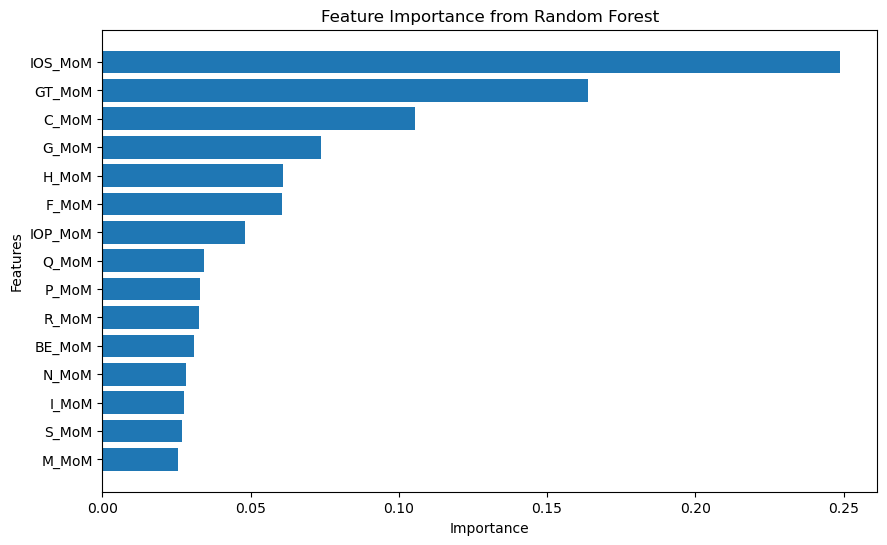

In [138]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assuming 'df' contains the original dataset with the columns from the correlation list
# and the target variable y
df=train_current.copy()
y = df['y']  # Target variable
top_columns = [
     'GT_MoM', 'IOS_MoM', 'H_MoM', 'P_MoM', 'G_MoM', 'Q_MoM', 'F_MoM',
    'N_MoM', 'R_MoM', 'C_MoM', 'IOP_MoM', 'BE_MoM', 'S_MoM', 'I_MoM', 'M_MoM'
]  # Features based on your correlation list

X = df[top_columns]

# Split into 80% training and 20% testing based on time
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Step 1: Train a Random Forest model to evaluate feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance and sort them
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()




## Training thr Base line model 

In [139]:
# Step 2: Select top 5 important features
top_features = feature_importance['Feature'].values
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Step 3: Train Linear Regression with selected features
linear_model = LinearRegression()
linear_model.fit(X_train_selected, y_train)

# Step 4: Make predictions and calculate MAE
y_pred_selected = linear_model.predict(X_test_selected)
mae_selected = mean_absolute_error(y_test, y_pred_selected)

print(f"MAE for Linear Regression with top selected features: {mae_selected}")

MAE for Linear Regression with top selected features: 0.2328117566875274


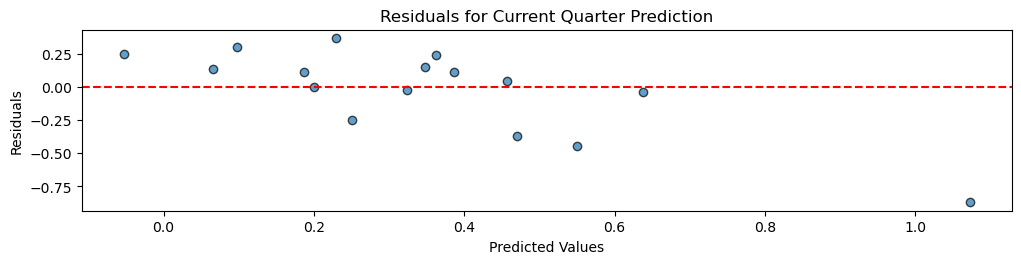

In [141]:
## Analyze Residuals:

# Step 1: Visualize residuals
residuals_current = y_test - y_pred_selected


plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.scatter(y_pred_selected, residuals_current, alpha=0.7, edgecolor='k')
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals for Current Quarter Prediction")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")



plt.show()



In [142]:
# Step 3: Train XGBoost Regressor
from xgboost import XGBRegressor

xgb_model_current = XGBRegressor()

xgb_model_current.fit(X_train_selected, y_train)

xgb_pred_current = xgb_model_current.predict(X_test_selected)

xgb_mae_current = mean_absolute_error(y_test, xgb_pred_current)

print(f"XGBoost MAE for current quarter prediction: {xgb_mae_current}")

XGBoost MAE for current quarter prediction: 0.22809472633525732
